In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def n_choose_k(n,k):
    num_permutations = np.math.factorial(n) / (np.math.factorial(k)*np.math.factorial(n-k))
    return int(num_permutations)

def n_hot_patterns(n,length):
    all_permutations = torch.tensor(list(itertools.product([0., 1.], repeat=length)))
    pattern_hotness = torch.sum(all_permutations,axis=1)
    idx = torch.where(pattern_hotness == n)[0]
    n_hot_patterns = all_permutations[idx]
    return n_hot_patterns

print(n_choose_k(7,2))
n_hot_patterns(n=2,length=4)

21


tensor([[0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.]])

In [3]:
class FBI_RNN(nn.Module):
    def __init__(self, input_size, output_size, fbi_size):
        super().__init__()
        self.out_size = output_size
        self.fbi_size = fbi_size
        self.in_size = input_size
        
        self.in2out = nn.Linear(self.in_size, self.out_size)
        self.fbi2out = nn.Linear(self.fbi_size, self.out_size, bias=False)
        self.out2fbi = nn.Linear(self.out_size, self.fbi_size)
        
        self.in2out.weight.data.uniform_(0, 1)
        self.fbi2out.weight.data.uniform_(-0.1, 0)
        self.out2fbi.weight.data.uniform_(0, 1)
        
            
    def forward(self, input_pattern, out, fbi, act_sharpness=50):
        out = self.in2out(input_pattern) + self.fbi2out(fbi)
        out = F.softplus(out, beta=act_sharpness+1)

        fbi = self.out2fbi(out)
        fbi = F.softplus(fbi, beta=act_sharpness+1)

        return out, fbi
    
        
    def train(self, num_epochs, num_timesteps, num_BPTT_steps, all_patterns, learning_rate):
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        num_patterns = all_patterns.shape[0]
        
        output_history = torch.zeros(self.out_size, num_timesteps, num_patterns)
        fbi_history = torch.zeros(self.fbi_size, num_timesteps, num_patterns)
        loss_history = []
        
        for epoch in tqdm(range(num_epochs)):
            for pattern_idx in torch.randperm(num_patterns):
                
                input_pattern = all_patterns[pattern_idx]
                target  = torch.eye(self.out_size)[pattern_idx]
                
                output = torch.zeros(self.out_size)
                fbi = torch.zeros(self.fbi_size)
                
                for t in range(num_timesteps): #iterate through all timepoints of the RNN
                    if t > (num_timesteps - num_BPTT_steps): #truncate BPTT to only evaluate n steps from the end
                        track_grad = True
                    else:
                        track_grad = False
                        
                    with torch.set_grad_enabled(track_grad):
                        output, fbi = self.forward(input_pattern,output,fbi,act_sharpness=3)
                        
                    if epoch == num_epochs-1: #store activities for final epoch
                        output_history[:,t,pattern_idx] = output.detach()
                        fbi_history[:,t,pattern_idx] = fbi.detach()

                loss = criterion(output, target)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_history.append(loss.detach())
                
                self.in2out.weight.data = self.in2out.weight.data.clamp(0,10)
                self.fbi2out.weight.data = self.fbi2out.weight.data.clamp(-10,0)
                self.out2fbi.weight.data = self.out2fbi.weight.data.clamp(0,10)
                
                
        print((2+epoch/100)**2)
            
        return output_history, fbi_history, loss_history

In [4]:
input_size = 7
output_size = n_choose_k(7,2)
fbi_size = 7

model = FBI_RNN(input_size, output_size, fbi_size)

In [5]:
num_epochs = 500
num_timesteps = 5
num_BPTT_steps = 2
lr = 0.001

all_patterns = n_hot_patterns(n=2,length=input_size)

output_history, fbi_history, loss_history = model.train(num_epochs, num_timesteps, num_BPTT_steps, all_patterns, lr)

100%|██████████| 500/500 [00:04<00:00, 107.32it/s]

48.8601


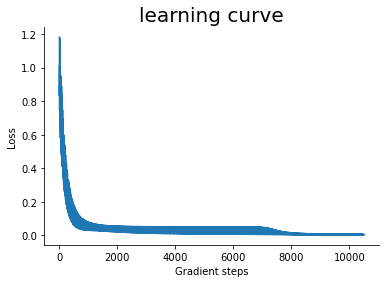

In [35]:
plt.plot(loss_history)
plt.xlabel('Gradient steps')
plt.ylabel('Loss')
plt.title('learning curve',fontsize=20)

sns.despine()
plt.show()

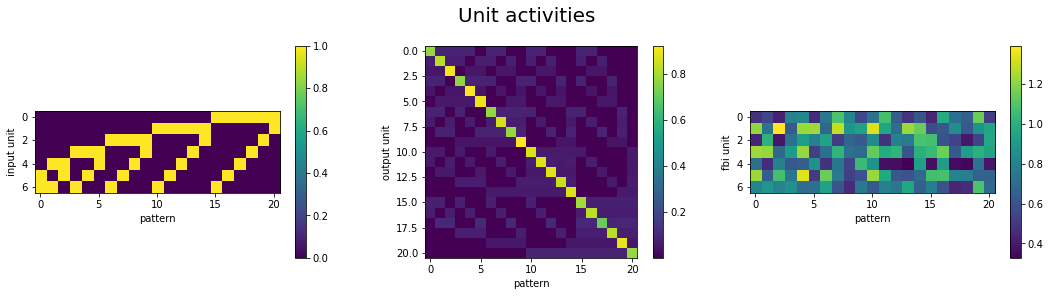

In [32]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

axis = 0
im = ax[axis].imshow(all_patterns.T,aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('input unit')

axis = 1
im = ax[axis].imshow(output_history[:,-1,:],aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('output unit')

axis = 2
im = ax[axis].imshow(fbi_history[:,-1,:],aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('fbi unit')

plt.suptitle("Unit activities",fontsize=20)
plt.tight_layout()
plt.show()

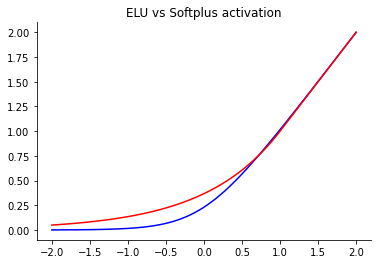

In [44]:
a = torch.linspace(-2,2,100)
plt.plot(a,F.softplus(a,beta=3),color='blue')
plt.plot(a,F.elu(a-1)+1,color='red')
plt.title('ELU vs Softplus activation')

sns.despine()
plt.show()

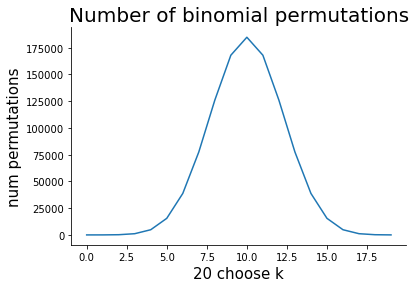

In [46]:
permutations = []
n = 20
for k in range(n):
    permutations.append(n_choose_k(n,k))

plt.plot(permutations)
plt.ylabel("num permutations",fontsize=15)
plt.xlabel(f"{n} choose k",fontsize=15)
plt.title('Number of binomial permutations',fontsize=20)

sns.despine()
plt.show()

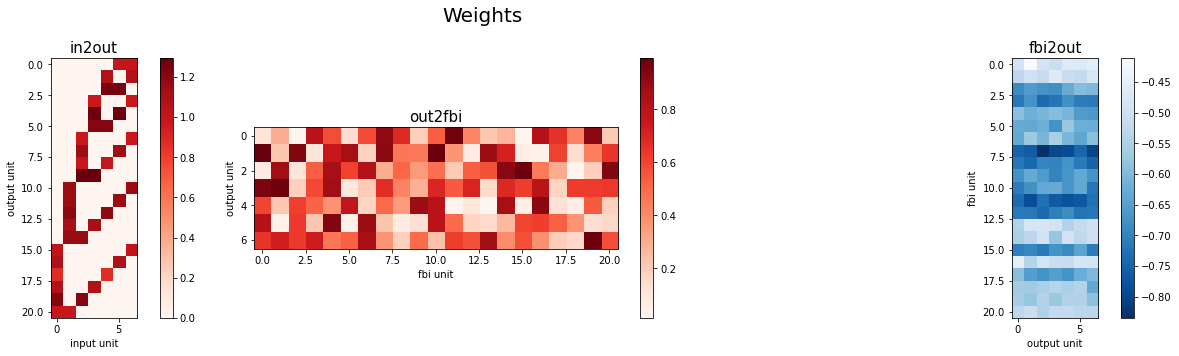

In [41]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

axis = 0
im = ax[axis].imshow(model.in2out.weight.data,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('input unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('in2out',fontsize=15)

axis = 1
im = ax[axis].imshow(model.out2fbi.weight.data,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('fbi unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('out2fbi',fontsize=15)

axis = 2
im = ax[axis].imshow(model.fbi2out.weight.data,aspect='equal',cmap='Blues_r')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('output unit')
ax[axis].set_ylabel('fbi unit')
ax[axis].set_title('fbi2out',fontsize=15)

plt.suptitle("Weights",fontsize=20)
plt.tight_layout()
plt.show()

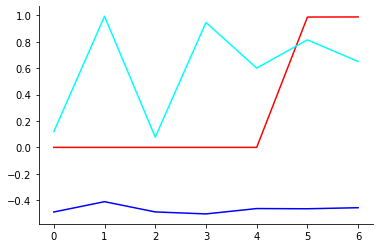

In [14]:
n = 0
plt.plot(model.in2out.weight.data[n],color='red')
plt.plot(model.out2fbi.weight.data[:,n],color='cyan')
plt.plot(model.fbi2out.weight.data[n],color='blue')

sns.despine()
plt.show()